# analysis of /var/log/auth.log 

data collected April 6, 2020 to April 25, 2020 on a DigitalOcean droplet running Ubuntu 18.04



In [1]:
# the order of installation matters for these two :(
!pip install python-geoip-geolite2
!pip install python-geoip-python3
#!pip install maxminddb-geolite2 # https://github.com/rr2do2/maxminddb-geolite2

In [2]:
import pandas
print('pandas',pandas.__version__)
import re # https://docs.python.org/3/library/re.html
from collections import Counter
import ipaddress # https://docs.python.org/3/library/ipaddress.html
import time
import sys
print(sys.version)
import matplotlib.pyplot as plt
from geoip import geolite2 # https://pythonhosted.org/python-geoip/


pandas 0.23.4
3.6.6 | packaged by conda-forge | (default, Oct 12 2018, 14:08:43) 
[GCC 4.8.2 20140120 (Red Hat 4.8.2-15)]


In [3]:
with open('auth.log','r') as f:
    lines = f.readlines()

In [4]:
lines[0]

'Apr  6 18:58:00 django-s-1vcpu-1gb-sfo2-01 systemd-logind[854]: Watching system buttons on /dev/input/event0 (Power Button)\n'

## convert list of lines into a list of dicts suitable for a Pandas dataframe

In [5]:
list_of_dicts = []
for indx, line in enumerate(lines):
    line_as_dict = {}

    # https://security.stackexchange.com/questions/18207/security-of-log-files-injecting-malicious-code-in-log-files/18209
    line = line.replace('\x00','') # there was a bad character on `lines[6615]`

#    line_as_dict['month'] = line[0:4].strip()
#    line_as_dict['day'] = line[4:6].strip()
#    line_as_dict['hour'] = line[6:9].strip()
#    line_as_dict['minute'] = line[10:12].strip()
#    line_as_dict['second'] = line[13:15].strip()
    line_as_dict['date time'] = line[0:15]
    line_as_list = line[16:].strip().split(' ')

#    if 'Apr' in line_as_list[0]:
#        print(indx)
#        print(line_as_dict)
#        print(line)
    line_as_dict['server name'] = line_as_list[0].strip()
    if '[' in line_as_list[1]: # https://serverfault.com/a/526151
        line_as_dict['service name'] = line_as_list[1].split('[')[0].strip()
        line_as_dict['pid'] = line_as_list[1].split('[')[1].replace(']:','').strip()
    else:
        line_as_dict['service name'] = line_as_list[1].strip()
    line_as_dict['message'] = ' '.join(line_as_list[2:])
    list_of_dicts.append(line_as_dict)

In [6]:
df = pandas.DataFrame(list_of_dicts)
df.shape

(9440, 5)

convert `date time` string to Python datetime

In [7]:
# https://strftime.org/
df['datetime'] = pandas.to_datetime('2020 ' + df['date time'], format='%Y %b %d %H:%M:%S')
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html
df.drop('date time', inplace=True, axis=1)

In [8]:
df.head()

,message,pid,server name,service name,datetime
0,Watching system buttons on /dev/input/event0 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00
1,Watching system buttons on /dev/input/event1 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00
2,New seat seat0.,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00
3,Server listening on 0.0.0.0 port 22.,1062,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:01
4,Server listening on :: port 22.,1062,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:01


check that the columns seem reasonable

In [9]:
df['server name'].value_counts()

django-s-1vcpu-1gb-sfo2-01                           6615
pythonflask-quickstart-ubuntu-s-1vcpu-1gb-nyc3-01    2825
Name: server name, dtype: int64

In [10]:
df['service name'].value_counts()

sshd                         8565
CRON                          714
sudo:                          83
systemd-logind                 25
polkitd(authority=local):      18
su                             10
systemd:                        7
groupadd                        6
usermod                         4
useradd                         3
polkit-agent-helper-1           2
chpasswd                        1
passwd                          1
chfn                            1
Name: service name, dtype: int64

## pid = process ID

one pid per login attempt; recycling of pids occurs

In [11]:
df['pid'].nunique()

2717

In [12]:
df['pid'].value_counts().head()

886     12
3730    10
870     10
1717     8
1709     8
Name: pid, dtype: int64

In [13]:
df['pid'].value_counts().tail()

1568     1
1732     1
20081    1
18459    1
20519    1
Name: pid, dtype: int64

In [14]:
# https://realpython.com/pandas-groupby/
# https://stackoverflow.com/questions/14734533/how-to-access-pandas-groupby-dataframe-by-key

df.groupby('pid').get_group('854').sort_values(["datetime"])

,message,pid,server name,service name,datetime
0,Watching system buttons on /dev/input/event0 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00
1,Watching system buttons on /dev/input/event1 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00
2,New seat seat0.,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00
24,New session 1 of user root.,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:59:15
71,Watching system buttons on /dev/input/event0 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 19:01:56
72,Watching system buttons on /dev/input/event1 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 19:01:56
266,New session 5 of user root.,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 19:17:56


In [15]:
df.groupby('pid').get_group('18171').sort_values(["datetime"])

,message,pid,server name,service name,datetime
8314,Connection closed by 218.89.250.77 port 46748 ...,18171,pythonflask-quickstart-ubuntu-s-1vcpu-1gb-nyc3-01,sshd,2020-04-25 03:49:50


In [16]:
df.loc[8314]['message']

'Connection closed by 218.89.250.77 port 46748 [preauth]'

# what user names are being attempted?

In [17]:
list_of_attempted_users = []
relevant_entries = []
for indx, msg in df['message'].items():
#    if msg.startswith('Invalid user '):
#        list_of_attempted_users.append(msg.replace('Invalid user ',''))
    if msg.startswith('Failed password for invalid user'):
        list_of_attempted_users.append(msg.replace('Failed password for invalid user ',''))
    elif msg.startswith('Failed password for '):
        list_of_attempted_users.append(msg.replace('Failed password for ',''))
    elif (msg.startswith('Disconnected from') or 
          msg.startswith('New session') or 
          msg.startswith('Invalid user ') or 
          msg.startswith('Received disconnect from ') or 
          msg.startswith('Connection closed by ') or 
          msg.startswith('Connection reset by ') or
          msg.startswith('Unable to negotiate with') or
          msg.startswith('PAM 2 more authentication failures') or
          msg.startswith('pam_unix(sshd:auth): authentication failure') or
          msg.startswith('error: Received disconnect from ') or
          msg.startswith('Did not receive identification string') or
          msg.startswith('message repeated 2 times: [ Failed password')):
        #print(msg)
        continue
    else:
        relevant_entries.append(msg)#[0:40])
#    if 'Failed password' in msg:
#        print(msg)

In [18]:
list_of_users = []
for entry in list_of_attempted_users:
    list_of_users.append(entry.split(' ')[0])

In [19]:
# https://stackoverflow.com/a/5829377/1164295
u = Counter(list_of_users)

In [20]:
# https://stackoverflow.com/a/55292813/1164295
sorted_u = {k: u[k] for k in sorted(u, key=u.get, reverse=True) if u[k]>3}

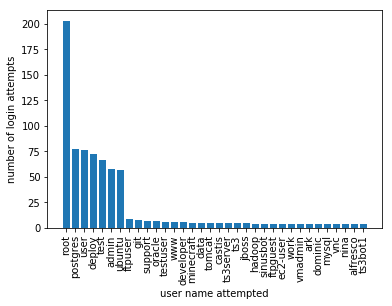

In [21]:
# https://stackoverflow.com/a/16014873/1164295
plt.bar(range(len(sorted_u)), list(sorted_u.values()), align='center')
_=plt.xticks(range(len(sorted_u)), list(sorted_u.keys()), rotation='vertical')
_=plt.ylabel('number of login attempts')
_=plt.xlabel('user name attempted')

### add username as column in df

In [22]:
def extract_username(msg):
    if msg.startswith('Failed password for invalid user '):
        return msg.replace('Failed password for invalid user ','').split(' ')[0]
    elif msg.startswith('Failed password for '):
        return msg.replace('Failed password for ','').split(' ')[0]
    elif msg.startswith('Invalid user '):
        return msg.replace('Invalid user ','').split(' ')[0]
    else:
        return None

In [23]:
df['username'] = df['message'].apply(extract_username)

In [24]:
df['username'].value_counts().head()

root      203
user      166
admin     163
test      146
deploy    144
Name: username, dtype: int64

In [25]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.notnull.html
df[df['username'].notnull()].head()

,message,pid,server name,service name,datetime,username
11,Failed password for root from 200.0.236.210 po...,1709,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:38,root
14,Invalid user ubuntu from 111.229.167.10 port 3...,1717,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:49,ubuntu
17,Failed password for invalid user ubuntu from 1...,1717,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:51,ubuntu
30,Failed password for root from 37.252.189.70 po...,2121,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 19:00:06,root
34,Failed password for root from 79.137.72.121 po...,3730,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 19:00:32,root


# look for IP addresses in the messages

In [26]:
list_of_ips = []
for indx, msg in df['message'].items():
    # https://www.regular-expressions.info/ip.html
    res = re.findall('(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.'+
                     '(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.'+
                     '(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.'+
                     '(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])',msg)
    if res:
        if len(res)>1:
            print(res)
        else:
#            print(indx)
            list_of_ips.append('.'.join(res[0]))
    

## sort by number of times the IP address appears in the logs

In [27]:
# https://stackoverflow.com/a/5829377/1164295
d = Counter(list_of_ips)

In [28]:
# https://stackoverflow.com/a/55292813/1164295
{k: d[k] for k in sorted(d, key=d.get, reverse=True)}

{'218.89.250.77': 246,
 '165.227.30.198': 187,
 '34.74.196.104': 148,
 '139.59.58.115': 148,
 '61.187.53.119': 147,
 '129.226.161.114': 146,
 '121.122.40.109': 146,
 '183.129.141.30': 146,
 '201.57.40.70': 146,
 '152.136.36.250': 146,
 '103.16.223.243': 145,
 '106.12.155.45': 145,
 '132.145.242.238': 145,
 '124.88.37.161': 145,
 '110.49.142.46': 144,
 '115.42.127.133': 144,
 '198.199.122.234': 142,
 '157.230.208.92': 141,
 '189.4.28.99': 140,
 '58.150.46.6': 139,
 '106.13.4.250': 138,
 '118.24.9.152': 136,
 '37.49.226.19': 136,
 '106.124.131.194': 135,
 '209.97.133.196': 132,
 '118.24.2.218': 130,
 '177.152.16.45': 124,
 '103.26.40.145': 122,
 '138.68.106.62': 122,
 '207.180.244.29': 122,
 '148.70.32.179': 115,
 '45.120.69.97': 113,
 '111.229.167.10': 101,
 '141.98.81.38': 100,
 '193.70.37.133': 100,
 '51.15.99.106': 97,
 '198.199.112.219': 96,
 '40.83.125.50': 85,
 '36.155.113.40': 84,
 '182.75.216.74': 82,
 '49.231.182.35': 77,
 '125.227.255.79': 73,
 '222.186.31.166': 71,
 '195.70.5

## sort by IP address

In [29]:
# https://www.python4networkengineers.com/posts/how_to_sort_ip_addresses_with_python/
for ip in sorted(list(d.keys()), key = lambda ip: ( int(ip.split(".")[0]), 
                                    int(ip.split(".")[1]), 
                                    int(ip.split(".")[2]), 
                                    int(ip.split(".")[3]))):
    print('"' + ip + '": ' + str(d[ip]) + ',')

"0.0.0.0": 6,
"1.10.141.248": 4,
"1.10.141.254": 10,
"1.251.0.135": 4,
"8.36.123.218": 1,
"14.98.4.82": 59,
"14.186.46.148": 2,
"23.95.89.71": 11,
"27.3.9.57": 1,
"31.13.131.138": 1,
"31.223.251.10": 1,
"34.74.196.104": 148,
"36.90.212.84": 1,
"36.155.113.40": 84,
"37.49.226.19": 136,
"37.252.189.70": 40,
"40.83.125.50": 85,
"41.38.206.180": 2,
"41.92.108.110": 1,
"42.159.201.45": 42,
"45.67.14.21": 2,
"45.83.66.227": 1,
"45.95.168.247": 18,
"45.95.168.251": 18,
"45.120.69.97": 113,
"49.88.112.69": 2,
"49.88.112.72": 2,
"49.231.182.35": 77,
"51.15.99.106": 97,
"51.77.212.235": 32,
"51.91.102.49": 1,
"51.91.140.218": 45,
"52.186.168.121": 18,
"58.11.27.198": 1,
"58.150.46.6": 139,
"61.19.146.226": 25,
"61.78.107.61": 5,
"61.187.53.119": 147,
"65.49.20.67": 1,
"65.49.20.68": 1,
"71.6.232.6": 1,
"71.244.214.232": 10,
"79.137.72.121": 36,
"80.82.64.124": 8,
"83.97.20.31": 1,
"88.146.200.8": 1,
"88.251.163.3": 1,
"89.248.174.3": 1,
"89.248.174.151": 2,
"92.118.161.41": 1,
"92.222.36.74": 5,

### append as column in df

In [30]:
def extract_ip(msg):
    res = re.findall('(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.'+
                     '(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.'+
                     '(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])\.'+
                     '(25[0-5]|2[0-4][0-9]|1[0-9][0-9]|[1-9]?[0-9])',msg)
    if len(res)==0:
        return None
    elif len(res)==1:
        return '.'.join(res[0])
    else:
        raise Exception(res)

In [31]:
df['message'][3]

'Server listening on 0.0.0.0 port 22.'

In [32]:
df['ip'] = df['message'].apply(extract_ip)

In [33]:
df.head()

,message,pid,server name,service name,datetime,username,ip
0,Watching system buttons on /dev/input/event0 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00,None,None
1,Watching system buttons on /dev/input/event1 (...,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00,None,None
2,New seat seat0.,854,django-s-1vcpu-1gb-sfo2-01,systemd-logind,2020-04-06 18:58:00,None,None
3,Server listening on 0.0.0.0 port 22.,1062,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:01,None,0.0.0.0
4,Server listening on :: port 22.,1062,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:01,None,None


# IP to geo using lookup table
data is from https://github.com/datasets/geoip2-ipv4/blob/master/data/geoip2-ipv4.csv

column definitions are at https://dev.maxmind.com/geoip/geoip2/geoip2-city-country-csv-databases/

In [34]:
geoip_df = pandas.read_csv('geoip2-ipv4.txt')

In [35]:
geoip_df.shape

(172754, 8)

In [36]:
geoip_df.head()

,network,geoname_id,continent_code,continent_name,country_iso_code,country_name,is_anonymous_proxy,is_satellite_provider
0,41.74.160.0/20,49518.0,AF,Africa,RW,Rwanda,0,0
1,41.77.160.0/22,49518.0,AF,Africa,RW,Rwanda,0,0
2,41.138.80.0/21,49518.0,AF,Africa,RW,Rwanda,0,0
3,41.186.0.0/16,49518.0,AF,Africa,RW,Rwanda,0,0
4,41.197.0.0/16,49518.0,AF,Africa,RW,Rwanda,0,0


to convert geoname to location, see

https://download.geonames.org/export/dump/
    
as per https://github.com/maxmind/GeoIP2-java/issues/103

## space-time trade-off: 
## search through all the permutations (CPU intensive) or store a lookup table in memory?

the brute force search would take too long

In [37]:
ipaddress.IPv4Address('192.0.2.6') in ipaddress.IPv4Network('192.0.2.0/28')

True

running the following for the full data set would consume more memory than my computer has :(

In [38]:
start_time = time.time()
ip_as_int_and_geoname_id = {}
for index, row in geoip_df.iloc[0:10].iterrows():
    #print(row['network'],row['geoname_id'])
    for addr in ipaddress.IPv4Network(row['network']):
        ip_as_int_and_geoname_id[int(addr)] = row['country_name']#row['geoname_id']
print('elapsed',round(time.time() - start_time,2),'seconds')

elapsed 5.28 seconds


In [39]:
len(ip_as_int_and_geoname_id)

147456

In [40]:
# https://docs.python.org/3/library/sys.html#sys.getsizeof
# Returns the size of an object in bytes
sys.getsizeof(ip_as_int_and_geoname_id)/(1024*1024)

5.000091552734375

In [41]:
sys.getsizeof(geoip_df)/(1024*1024)

55.355018615722656

## decrease granularity and increase likelihood of misattribution

This wasn't successful. 

I tried both "first two octets" (which yield a bunch of countries per IP) and "first three octets" (which yielded very few matches)

## use a library

In [42]:
def get_country(ip):
#    ip_as_bytes = bytes(ip, 'ascii')
    match = geolite2.lookup(ip)
    print(match)
    if match:
        return match.country
    else:
        return None

In [43]:
get_country('103.26.40.145')

<IPInfo ip='103.26.40.145' country='SG' continent='AS' subdivisions=frozenset() timezone='Asia/Singapore' location=(1.3667, 103.8)>


'SG'

download country code lookup table from https://dev.maxmind.com/geoip/legacy/codes/iso3166/

https://dev.maxmind.com/static/csv/codes/iso3166.csv

In [44]:
country_code_df = pandas.read_csv('iso3166.csv', header=None, names=['country code', 'name'])
country_code_df.shape

(254, 2)

In [45]:
country_code_df.head()

,country code,name
0,A1,Anonymous Proxy
1,A2,Satellite Provider
2,O1,Other Country
3,AD,Andorra
4,AE,United Arab Emirates


In [46]:
country_code_df[country_code_df['country code']=='SG']['name'].values[0]

'Singapore'

In [47]:
def get_country(ip):
    match = geolite2.lookup(ip)
    if match:
        return country_code_df[country_code_df['country code']==match.country]['name'].values[0]
    else:
        return None

In [48]:
get_country('103.26.40.145')

'Singapore'

In [49]:
def country_if_ip(ip):
    if ip:
        return get_country(ip)
    else:
        return None

In [50]:
df['country'] = df['ip'].apply(country_if_ip)

In [52]:
df[df['username'].notnull()].head()

,message,pid,server name,service name,datetime,username,ip,country
11,Failed password for root from 200.0.236.210 po...,1709,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:38,root,200.0.236.210,Argentina
14,Invalid user ubuntu from 111.229.167.10 port 3...,1717,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:49,ubuntu,111.229.167.10,China
17,Failed password for invalid user ubuntu from 1...,1717,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 18:58:51,ubuntu,111.229.167.10,China
30,Failed password for root from 37.252.189.70 po...,2121,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 19:00:06,root,37.252.189.70,Austria
34,Failed password for root from 79.137.72.121 po...,3730,django-s-1vcpu-1gb-sfo2-01,sshd,2020-04-06 19:00:32,root,79.137.72.121,Italy


In [56]:
df['country'].value_counts().head(10)

China                 2784
United States         1881
Brazil                 421
Thailand               282
United Kingdom         176
Indonesia              161
Korea, Republic of     148
Australia              148
Netherlands            148
Malaysia               147
Name: country, dtype: int64